In [3]:
import numpy as np
import netCDF4 as nc
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import netCDF4 as nc
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np
from math import radians, cos, sin, asin, sqrt
import pandas as pd
import pickle

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


- 需要注意读取的路径不能有中文的字符
- 目前的问题是用的是cmax，需要重新选择相应的公式  
- 目前已经成功获得了10%均匀采样的数据
- 注意pytho2和python3的区别，除法的结果
- tensor.view里面的-1表示infer的维度

In [2]:
def plot_distribution(data_array: np.array):
    """
    输入二维的array，输出相应的面积图片
    这里人为定义了vmax的数值，之后可能需要改改
    """
    shape = data_array.shape
    x = np.arange(0, shape[1])  # len = 11
    y = np.arange(0, shape[0])  # len = 7

    fig, ax = plt.subplots(dpi=150)
    pcm = ax.pcolormesh(x, y, data_array, vmax=data_array.max(), vmin=0, cmap="Blues")
    fig.colorbar(pcm, ax=ax)


# plot_distribution(O3_con)

## 提取O3的数据

In [4]:
def get_name_lis(basePath):
    """
    获得数据的名称列表
    """
    names = os.listdir(basePath)
    return names


basePath = "data/china_camx_original/"
names = get_name_lis(basePath)

In [87]:
def process_netCDF_get_O3():
    """获得O3的数据，保存在data_O3_numpy里面"""
    basePath = "data/china_camx_original/"
    for name in names:
        path = basePath + name
        file_obj = nc.Dataset(path)
        O3 = file_obj.variables["O3"][:]
        O3_array = np.array([i[0] for i in O3])
        #     print(O3_array.shape)


#         np.save("data_O3_numpy/{}.npy".format(name[39:47]), O3_array)
# process_netCDF_get_O3()

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.03668347 0.03684755 ... 0.04016238 0.04008532 0.        ]
  [0.         0.03592238 0.03587604 ... 0.04013048 0.04009419 0.        ]
  ...
  [0.         0.03938932 0.03945024 ... 0.03955558 0.0395021  0.        ]
  [0.         0.03945096 0.03952968 ... 0.03961331 0.03951626 0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.03283278 0.03291294 ... 0.04081001 0.04054488 0.        ]
  [0.         0.0321149  0.03112836 ... 0.04078054 0.04051123 0.        ]
  ...
  [0.         0.03853346 0.03863519 ... 0.0392476  0.03918027 0.        ]
  [0.         0.03871232 0.03895664 ... 0.03925656 0.03922308 0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.033476

# check data range

In [47]:
base = "data/pm25_hourly/"
res = []
for name in os.listdir(base):
    path = base + name
    arr = np.load(path, allow_pickle=True)
    stat = [arr.min(), round(arr.max(), 4), round(arr.mean(), 4)]
    df = pd.DataFrame(arr.reshape((216 * 270, 1)))
    stat.append(df[df > 0].count() / (216 * 270.0))
    res.append(stat)
#     print(stat)

In [51]:
# cal max and min
np.min([i[0] for i in res])

0.0

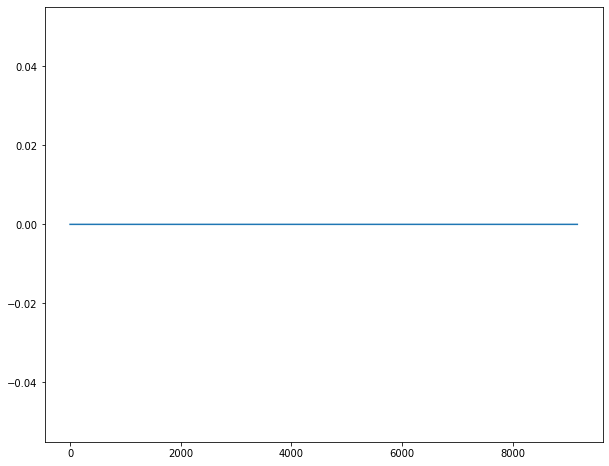

In [104]:
plt.figure(figsize=(10, 8))
plt.plot([i[0] for i in res])

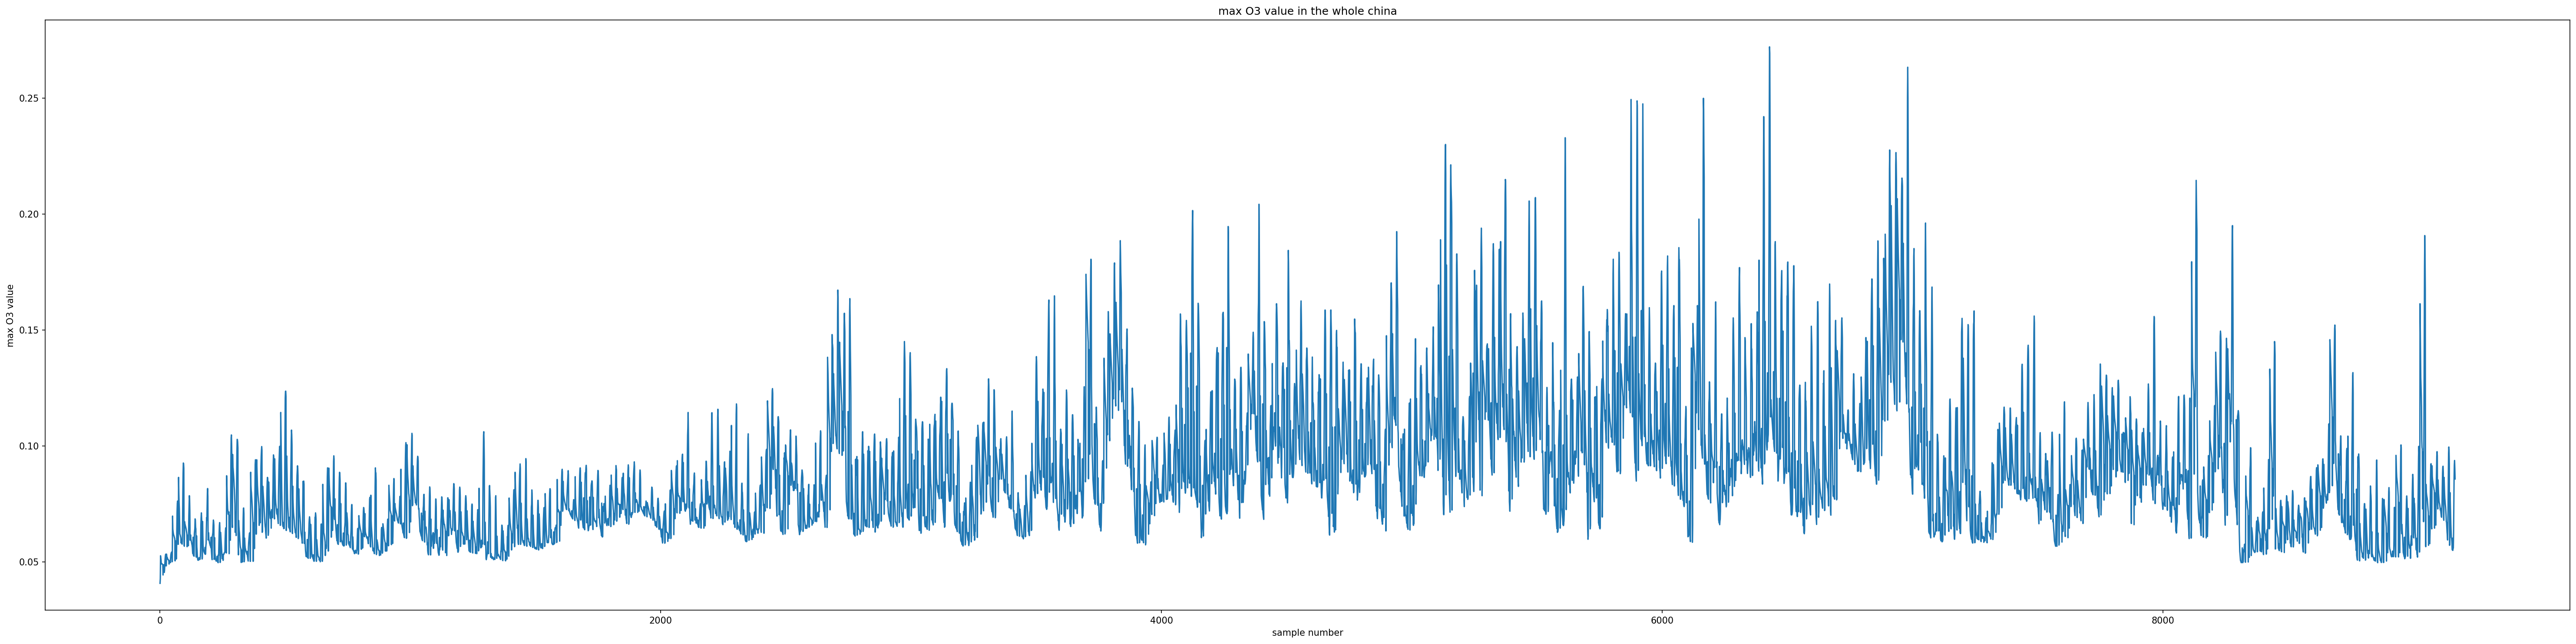

In [99]:
plt.figure(figsize=(50, 12), dpi=150)
plt.plot([i[1] for i in res])
plt.xlabel("sample number")
plt.ylabel("max O3 value")
plt.title("max O3 value in the whole china")
plt.savefig("saved/max_o3_hourly_sample.jpg")

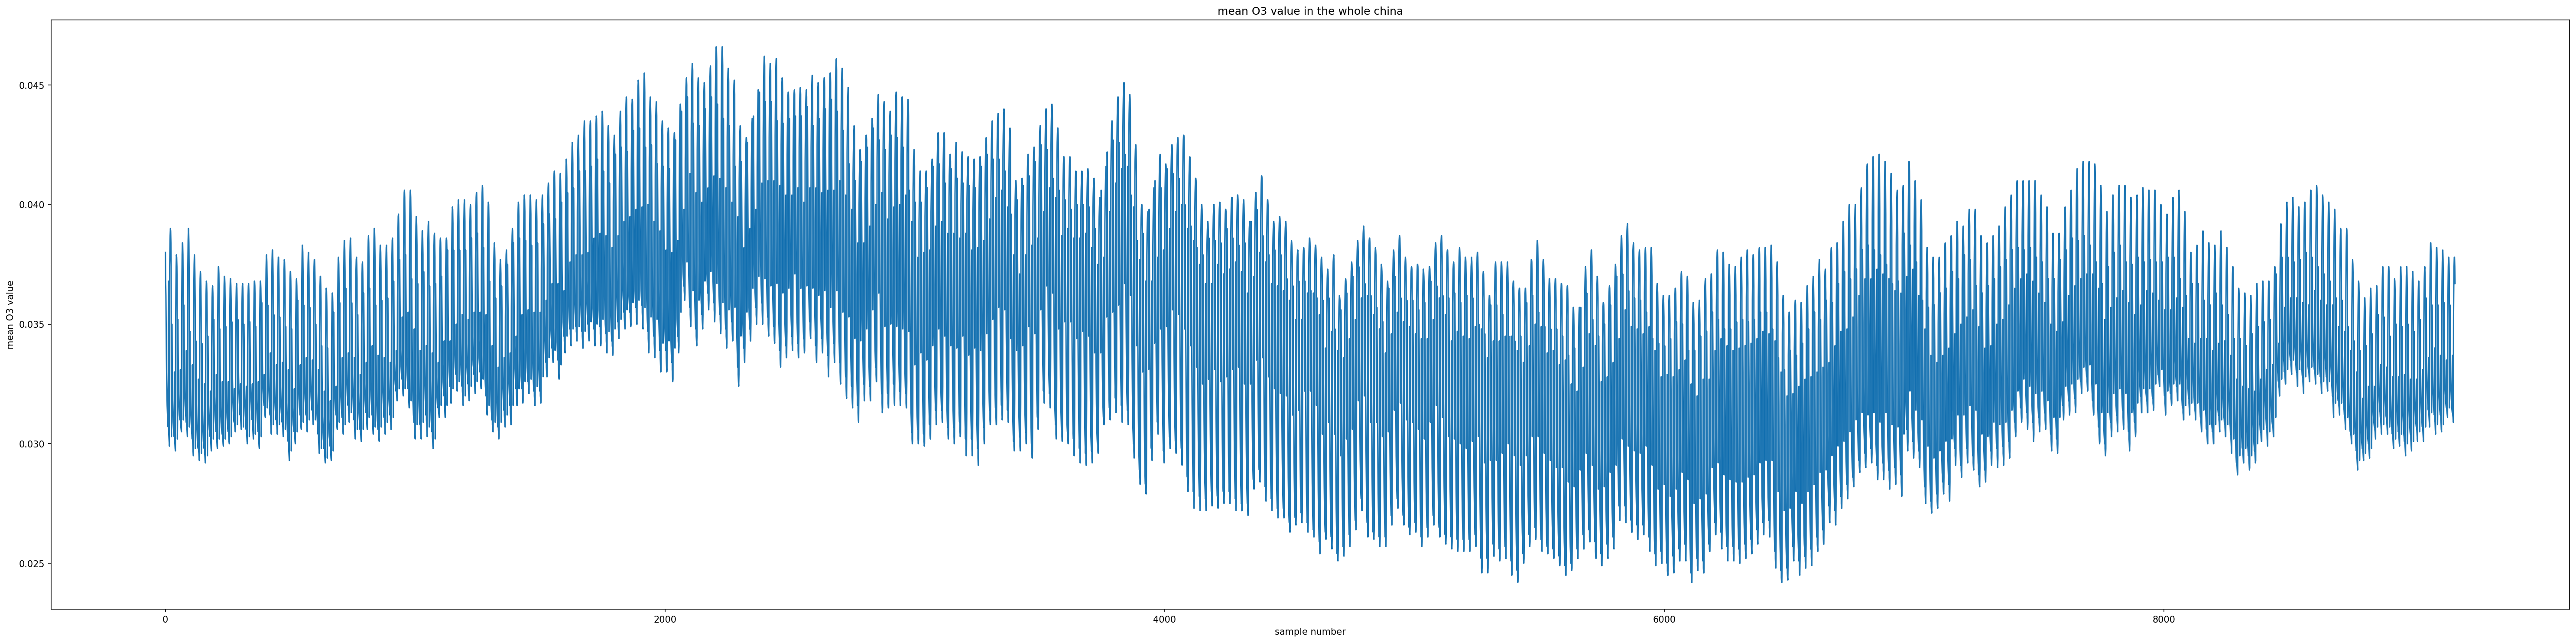

In [108]:
plt.figure(figsize=(50, 12), dpi=150)
plt.plot([i[2] for i in res])
plt.xlabel("sample number")
plt.ylabel("mean O3 value")
plt.title("mean O3 value in the whole china")
plt.savefig("saved/mean_o3_hourly_check.jpg")

# compare with original

In [6]:
def cal_distance_helper(lon1, lat1, lon2, lat2):  # 经度1，纬度1，经度2，纬度2 （十进制度数）
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    输出：距离km
    """
    # 将十进制度数转化为弧度
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine公式
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # 地球平均半径，单位为公里
    return c * r


def cal_distance(location1: tuple, location2: tuple) -> float:
    return cal_distance_helper(location1[0], location1[1], location2[0], location2[1])


def get_nearist_index(location_array: np.array, location: tuple) -> tuple:
    """
    input: the array stored all the location; the location
    output: the location index (i, j), not the (lon,lat)
    """
    minDis, index = None, (0, 0)
    for i in range(len(location_array)):
        for j in range(len(location_array[0])):
            dis = cal_distance(location, location_array[i][j])
            if not minDis:
                minDis = dis
            if dis < minDis:
                minDis = dis
                index = (i, j)
    return index


def get_location_array(basePath):
    # print(os.listdir())
    nameList = os.listdir(basePath)
    path = basePath + nameList[10]
    file_obj = nc.Dataset(path)
    lon = file_obj.variables["longitude"][:]
    lat = file_obj.variables["latitude"][:]

    res_arr = np.zeros((216, 270), dtype="object")
    for i in range(len(lon)):
        for j in range(len(lon[0])):
            res_arr[i][j] = (lon[i][j], lat[i][j])
    return res_arr

In [69]:
def get_camx_station_data(loc: tuple, dataType="O3") -> pd.DataFrame:
    """
    input the station location (lon, lat), dataType = O3 or PM25
    return the O3 dateframe of that station
    """
    # loc -> index
    basePath = "data/china_camx_original/"
    arr = get_location_array(basePath)

    loc = get_nearist_index(arr, loc)

    base = "data/{}_hourly/".format(dataType)
    names = os.listdir(base)

    # get value from the index, add time info
    res = []
    for name in names:
        path = base + name
        arr = np.load(path, allow_pickle=True)
        res.append(
            [
                int(name[:4]),
                int(name[4:6]),
                int(name[6:8]),
                int(name[9 : name.find(".")]),
                arr[loc[0]][loc[1]],
            ]
        )
    # to dataframe and add timestemp
    df = pd.DataFrame(res, columns=["year", "month", "day", "hour", "value"])
    time_list = []
    for i, row in df.iterrows():

        string = (
            "-".join([str(int(i)) for i in [row.year, row.month, row.day]])
            + " "
            + str(int(row.hour))
            + ":00"
        )
        t = pd.Timestamp(string)
        time_list.append(t)
    df["pubtime"] = time_list
    return df


df = get_camx_station_data((87.5801, 43.8303), "O3")

In [68]:
def get_monitor_data(path):
    """
    get the shanghai xuhui data
    """
    df_real = pd.read_csv(path)
    df_real["pubtime"] = pd.to_datetime(df_real.pubtime)
    return df_real


path = "data/xinjiang_wulumuqi_2019.csv"
df_real = get_monitor_data(path)

In [70]:
df_m = pd.merge(df_real, df, on="pubtime")[["pubtime", "value", "o3"]]

df_m["value"] = df_m["value"].apply(lambda x: 1000 * 44.3 * x / 22.4)

df_m.index = pd.DatetimeIndex(df_m["pubtime"])
df_d = df_m.resample("d").mean()

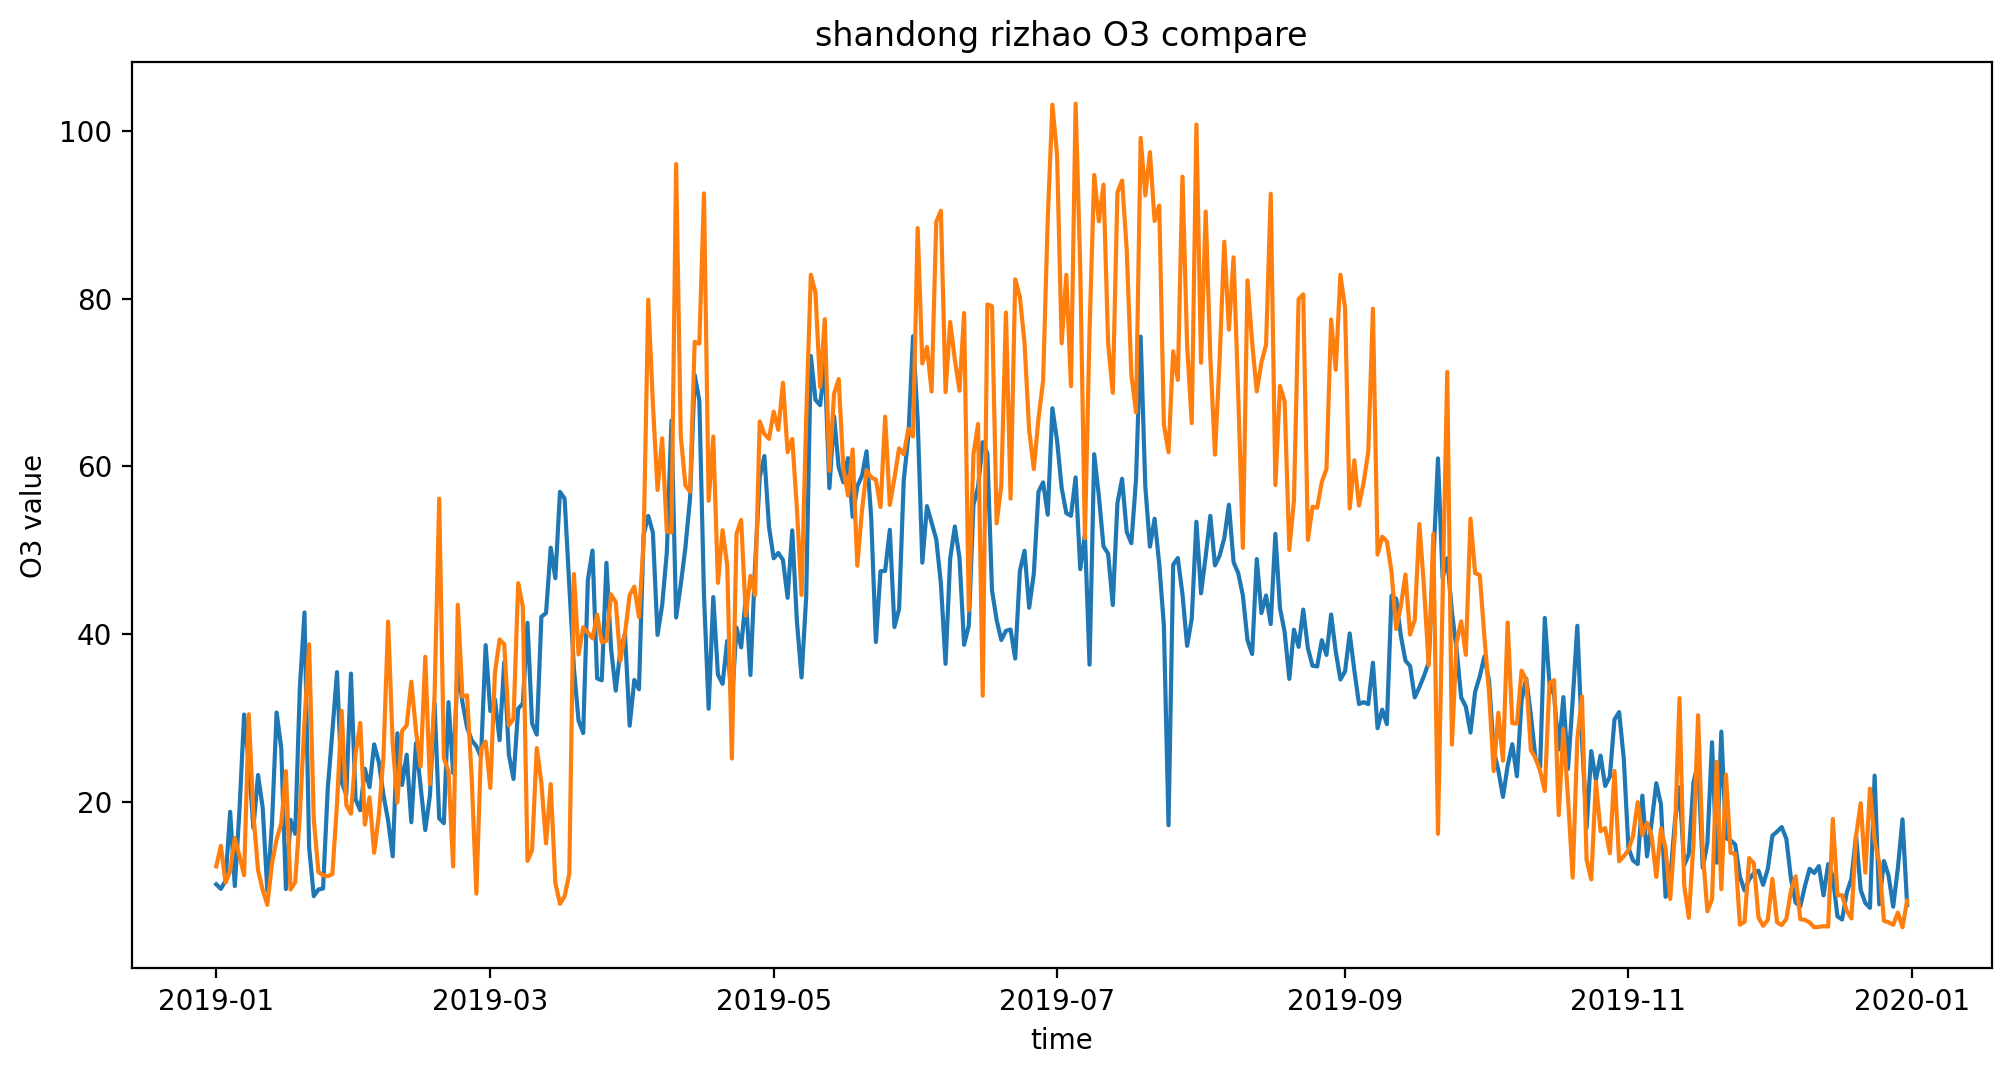

In [71]:
station = "shandong rizhao"
dataType = "O3"
plt.figure(figsize=(12, 6), dpi=200)
plt.plot(df_d)
plt.title("{} {} compare".format(station, dataType))
plt.xlabel("time")
plt.ylabel("{} value".format(dataType))
plt.savefig("saved/{}_{}_compare.jpg".format(station, dataType))

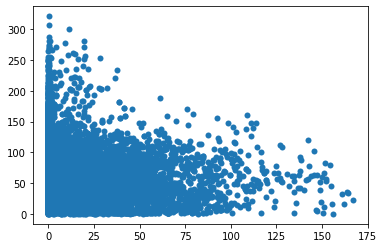

In [38]:
plt.scatter(df_m.o3_value, df_m.o3, linewidths=0.001)

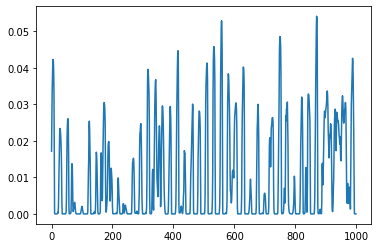

In [18]:
plt.plot(df_merge.O3_value[:1000])

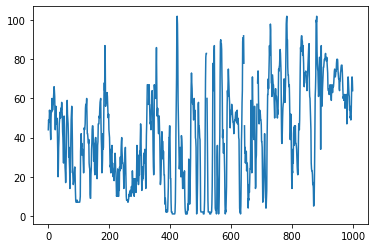

In [19]:
plt.plot(df_merge.o3[:1000])

### 看看经度的左右是否符合要求

In [5]:
path = "china_camx/"+names[200]
print(path)
file_obj = nc.Dataset(path)

china_camx/CAMx.v6.50.China20km_nox_1.00_voc_1.00.20190703.avrg.grd01.nc


In [310]:
lon = file_obj.variables["longitude"][:]
lat = file_obj.variables["latitude"][:]
round(lat.min(),2), round(lat.max(),2)

(15.03, 55.88)

In [293]:
file_obj.variables.keys()

dict_keys(['X', 'Y', 'layer', 'TFLAG', 'ETFLAG', 'longitude', 'latitude', 'topo', 'z', 'NO2', 'SO2', 'O3', 'CO', 'H2O2', 'HNO3', 'PNO3', 'PSO4', 'PNH4', 'POA', 'SOA1', 'SOA2', 'SOA3', 'SOA4', 'SOPA', 'SOPB', 'PEC', 'FPRM', 'FCRS', 'CPRM', 'CCRS'])

In [294]:
name_list = ['PNO3','PSO4','PNH4','POA','SOA1','SOA2',\
             'SOA3','SOA4','SOPA','SOPB','PEC','FPRM','FCRS']

In [295]:
array = np.zeros((24, 1, 216, 270))
for name in name_list:
    print(name)
    array = array + np.array(file_obj.variables[name][:], dtype=float)

PNO3
PSO4
PNH4
POA
SOA1
SOA2
SOA3
SOA4
SOPA
SOPB
PEC
FPRM
FCRS


<ipython-input-298-a4b26dcc9da9>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = ax.pcolormesh(x, y, data_array, vmax=data_array.max(), vmin=0, cmap='Blues')


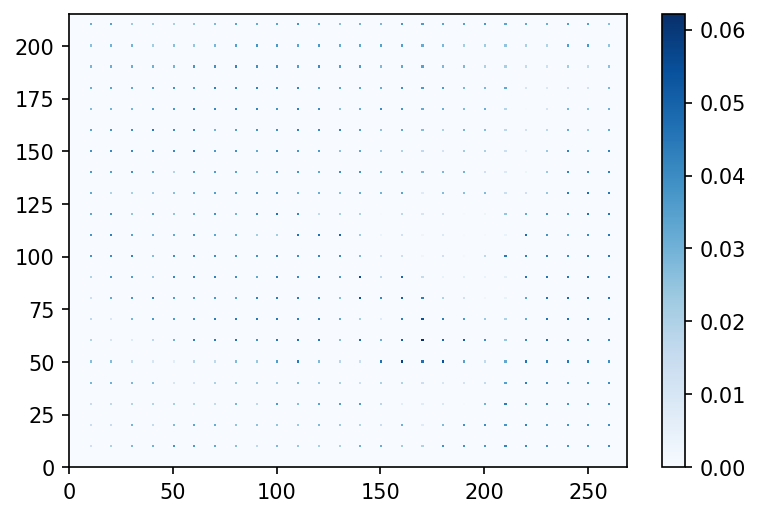

In [311]:
plot_distribution(np.load("data_O3_sample_numpy/20190104-sample.npy")[0])

In [270]:
array.max()

179.42607485841884

In [265]:
file_obj.variables['PNO3'][:] + file_obj.variables['PSO4'][:]

masked_array(
  data=[[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 2.58522181e-09, 3.36226380e-09, ...,
           3.28338672e-08, 5.60596511e-08, 0.00000000e+00],
          [0.00000000e+00, 6.98326375e-09, 2.64681113e-08, ...,
           2.55112820e-08, 4.14938341e-08, 0.00000000e+00],
          ...,
          [0.00000000e+00, 7.17500516e-04, 7.79976021e-04, ...,
           3.32967658e-03, 3.16928793e-03, 0.00000000e+00],
          [0.00000000e+00, 4.95419197e-04, 6.80978468e-04, ...,
           3.38064763e-03, 3.34681477e-03, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]],


        [[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 1.35982337e-08, 5.18216901e-08, ...,
           1.23516401e-07, 9.664913

<ipython-input-298-a4b26dcc9da9>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = ax.pcolormesh(x, y, data_array, vmax=data_array.max(), vmin=0, cmap='Blues')


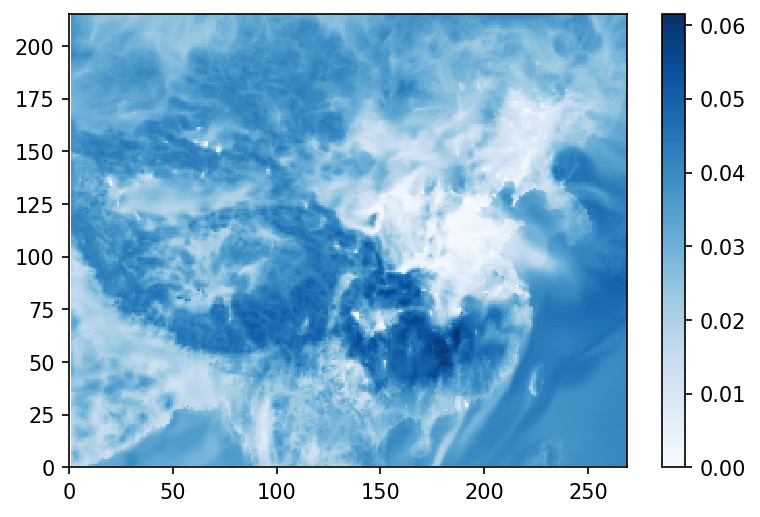

In [306]:
plot_distribution(np.load("data_O3_numpy/20190102.npy")[0])

## 将O3的数据进行采样，获得采样的数据

In [17]:
names_o3 = get_name_lis("data_O3_numpy/")

In [49]:
def get_sample_O3_data():
    '''将数据按照10%进行采样，得到相应的sample的数据，没采样的部分设置为0
    最后一天因为不够24hour，所以函数失败了'''
    xIndex = [i for i in range(0, 216, 10)]
    yIndex = [i for i in range(0, 270, 10)]

    for name in names_o3[:]:
        array_res = np.zeros((24, 216, 270))
        base = "data_O3_numpy/"
        array_24 = np.load(base+name)
        
    #     print(name)
        for hour in range(array_24.shape[0]):
            for x in xIndex:
                for y in yIndex:
                    array_res[hour][x][y] = array_24[hour][x][y]
    #         plot_distribution(array_res[hour])
        np.save("data_O3_sample_numpy/{}-sample.npy".format(name[:name.find(".")]), array_res)

In [50]:
get_sample_O3_data()

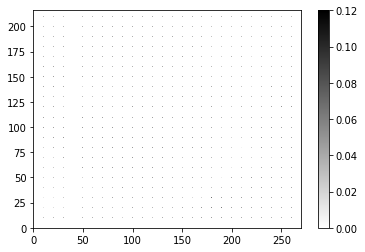

In [53]:
plot_distribution(np.load("data_O3_sample_numpy/20191226-sample.npy")[3])

## 尝试构建模型

In [55]:
import torch
import torch.nn as nn

In [253]:
class Generator(nn.Module):
    def __init__(self, nc, ngf):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(nc,ngf,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ngf),
                                 nn.LeakyReLU(0.2,inplace=True))
        # 16 x 16 x 64
        self.layer2 = nn.Sequential(nn.Conv2d(ngf,ngf*2,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ngf*2),
                                 nn.LeakyReLU(0.2,inplace=True))
        # 8 x 8 x 128
        
        self.layer3 = nn.Sequential(nn.Conv2d(ngf*2,ngf*4,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ngf*4),
                                 nn.LeakyReLU(0.2,inplace=True))
        # 4 x 4 x 256                     
        # 4 x 4 x 256
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(ngf*4,ngf*2,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ngf*2),
                                 nn.ReLU())
        # 8 x 8 x 128
        self.layer5 = nn.Sequential(nn.ConvTranspose2d(ngf*2,ngf,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ngf),
                                 nn.ReLU())
        # 16 x 16 x 64
        self.layer6 = nn.Sequential(nn.ConvTranspose2d(ngf,nc,kernel_size=4,stride=2,padding=1),
                                 nn.Tanh())
        # 32 x 32 x 1
    def forward(self,_cpLayer):
        out = self.layer1(_cpLayer)
        print(out.shape)
        out = self.layer2(out)
        print(out.shape)
        out = self.layer3(out)
        print(out.shape)
        out = self.layer4(out)
        print(out.shape)
        out = self.layer5(out)
        print(out.shape)
        out = self.layer6(out)
        print(out.shape)
        return out
class Discriminator(nn.Module):
    def __init__(self,nc,ndf):
        super(Discriminator,self).__init__()
        self.layer1_image = nn.Sequential(nn.Conv2d(nc,ndf//2,kernel_size=4,stride=2,padding=1),
                                 #nn.BatchNorm2d(ndf/2),
                                 nn.LeakyReLU(0.2,inplace=True))
        # 16 x 16
        self.layer1_cp = nn.Sequential(nn.Conv2d(nc,ndf//2,kernel_size=4,stride=2,padding=1),
                                 #nn.BatchNorm2d(ndf/2),
                                 nn.LeakyReLU(0.2,inplace=True))
        # 16 x 16
        self.layer2 = nn.Sequential(nn.Conv2d(ndf,ndf*2,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ndf*2),
                                 nn.LeakyReLU(0.2,inplace=True))
        # 8 x 8
        
        self.layer3 = nn.Sequential(nn.Conv2d(ndf*2,ndf*4,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ndf*4),
                                 nn.LeakyReLU(0.2,inplace=True))
        # 4 x 4
        
        self.layer4 = nn.Sequential(nn.Conv2d(ndf*4,1,kernel_size=4,stride=1,padding=0),
                                 nn.Sigmoid())
        # 1
#         self.layer5 = nn.Sequential(nn.Linear(, 1),
#                                  nn.Sigmoid())
        
    def forward(self,dem,_cpLayer):
        print(dem.shape)
        out_1 = self.layer1_image(dem)
        print(out_1.shape)
        out_2 = self.layer1_cp(_cpLayer)        
        out = self.layer2(torch.cat((out_1,out_2),1))
        print("concat", out.shape)
        out = self.layer3(out)
        print(out.shape)
        out = self.layer4(out)
        print(out.shape)
#         out = self.layer5(out)
#         print(out.shape)
        return out


In [250]:
tmp = torch.tensor([[1,2,4],[2,5,3]])
tmp, tmp.view(1,-1)

(tensor([[1, 2, 4],
         [2, 5, 3]]),
 tensor([[1, 2, 4, 2, 5, 3]]))

In [251]:
D = Discriminator(1, 32)

In [252]:
# res = G.forward(img)
res = D.forward(img, img)
res.shape

torch.Size([1, 1, 216, 270])
torch.Size([1, 16, 108, 135])
torch.Size([1, 64, 54, 67])
torch.Size([1, 128, 27, 33])
torch.Size([1, 1, 24, 30])


torch.Size([1, 1, 24, 30])

In [239]:
torch.randn(128, 20)[0].shape

torch.Size([20])

In [227]:
G = Generator(1, 64)
G = G.double()

In [236]:
img.view(img.size()[0], -1)

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

In [232]:
img

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [187]:
arr = np.load("data_O3_sample_numpy/20191226-sample.npy")[3]

In [188]:
arr[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [189]:
arr2 = arr[np.newaxis,np.newaxis,:,:]

In [190]:
arr2.shape

(1, 1, 216, 270)

In [191]:
img = torch.from_numpy(arr2)

In [192]:
img.double()

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [177]:
plot = res.detach().numpy()

In [199]:
res.shape

torch.Size([1, 256, 24, 30])

<ipython-input-182-4bd1457136d2>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = ax.pcolormesh(x, y, data_array, vmax=data_array.max(), vmin=0, cmap='binary')


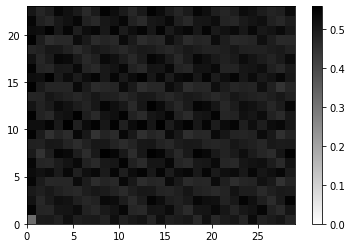

In [183]:
plot_distribution(plot[0][0])